# Viral Tweets Prediction Challenge
The goal of this competition is to develop a machine learning model to predict the virality level of each tweet based on attributes such as tweet content, media attached to the tweet, and date/time published.

## Import libraries

In [29]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Model building
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

## Load Data

In [17]:
# Local storage path
tweets_path = "Dataset/Tweets/"
users_path = "Dataset/Users/"

# Training datasets
train_tweets = pd.read_csv(tweets_path + 'train_tweets.csv')
train_tweets_vectorized_media = pd.read_csv(tweets_path + 'train_tweets_vectorized_media.csv')
train_tweets_vectorized_text = pd.read_csv(tweets_path + 'train_tweets_vectorized_text.csv')

# Test dataset
test_tweets = pd.read_csv(tweets_path + 'test_tweets.csv')
test_tweets_vectorized_media = pd.read_csv(tweets_path + 'test_tweets_vectorized_media.csv')
test_tweets_vectorized_text = pd.read_csv(tweets_path + 'test_tweets_vectorized_text.csv')

# User dataset
users = pd.read_csv(users_path + 'users.csv')
user_vectorized_descriptions = pd.read_csv(users_path + 'user_vectorized_descriptions.csv')
user_vectorized_profile_images = pd.read_csv(users_path + 'user_vectorized_profile_images.csv')

## Dimensions of Data

In [20]:
# print dimensions of data
print('Dimensions:')
print('Train tweets:', train_tweets.shape)
print('Train tweets vectorized media:', train_tweets_vectorized_media.shape)
print('Train tweets vectorized text:', train_tweets_vectorized_text.shape)
print()

print('Test tweets:', test_tweets.shape)
print('Test tweets vectorized media:', test_tweets_vectorized_media.shape)
print('Test tweets vectorized text:', test_tweets_vectorized_text.shape)
print()

print('Users:', users.shape)
print('User vectorized descriptions:', user_vectorized_descriptions.shape)
print('User vectorized profile images:', user_vectorized_profile_images.shape)

Dimensions:
Train tweets: (29625, 14)
Train tweets vectorized media: (21010, 2050)
Train tweets vectorized text: (29625, 769)

Test tweets: (12697, 13)
Test tweets vectorized media: (8946, 2050)
Test tweets vectorized text: (12697, 769)

Users: (52, 11)
User vectorized descriptions: (52, 769)
User vectorized profile images: (52, 2049)


# Exploratory Data Analysis

## Train Tweets

In [21]:
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2.0,1.0,0.0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0.0,1.0,0.0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0.0,1.0,1.0,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2.0,1.0,0.0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


In [24]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                29625 non-null  int64  
 1   tweet_user_id           29625 non-null  int64  
 2   tweet_created_at_year   29625 non-null  int64  
 3   tweet_created_at_month  29625 non-null  int64  
 4   tweet_created_at_day    29625 non-null  int64  
 5   tweet_created_at_hour   29625 non-null  int64  
 6   tweet_hashtag_count     29625 non-null  float64
 7   tweet_url_count         29625 non-null  float64
 8   tweet_mention_count     29625 non-null  float64
 9   tweet_has_attachment    29625 non-null  bool   
 10  tweet_attachment_class  29625 non-null  object 
 11  tweet_language_id       29625 non-null  int64  
 12  tweet_topic_ids         25340 non-null  object 
 13  virality                29625 non-null  int64  
dtypes: bool(1), float64(3), int64(8), obje

### Tweet Creation Date
tweet_created_at_year  
tweet_created_at_day  
tweet_created_at_month  
tweet_created_at_hour

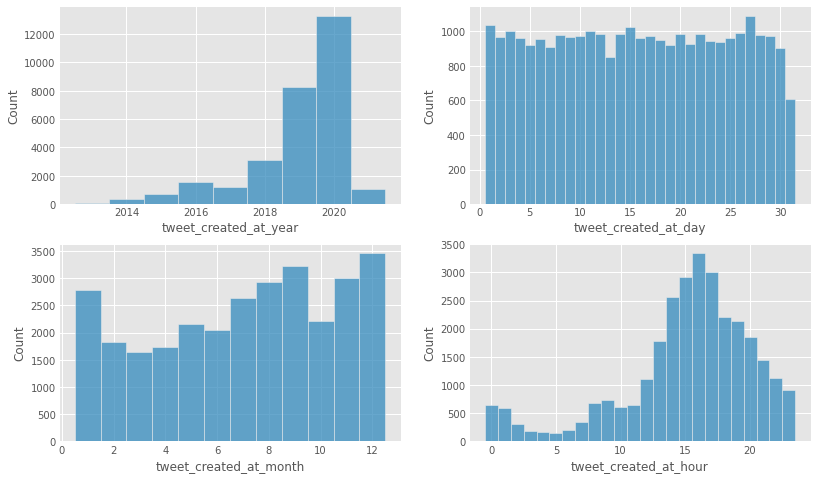

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(train_tweets, x = 'tweet_created_at_year', discrete = True, ax = axs[0,0])
sns.histplot(train_tweets, x = 'tweet_created_at_day', discrete = True, ax = axs[0,1])
sns.histplot(train_tweets, x = 'tweet_created_at_month', discrete = True, ax = axs[1,0])
sns.histplot(train_tweets, x = 'tweet_created_at_hour', discrete = True, ax = axs[1,1])
plt.show()

### Tweet Message Content
tweet_hashtag_count  
tweet_url_count  
tweet_mention_count

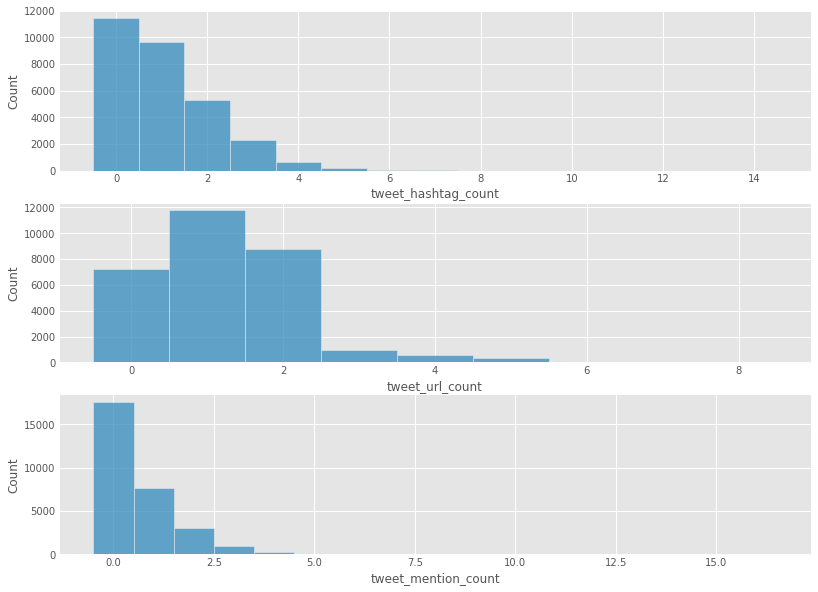

In [69]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

sns.histplot(x = 'tweet_hashtag_count', data = train_tweets, discrete = True, ax = axs[0])
sns.histplot(x = 'tweet_url_count', data = train_tweets, discrete = True, ax = axs[1])
sns.histplot(x = 'tweet_mention_count', data = train_tweets, discrete = True, ax = axs[2])
plt.show()

### Tweet Attatchment
tweet_has_attachment   
tweet_attachment_class

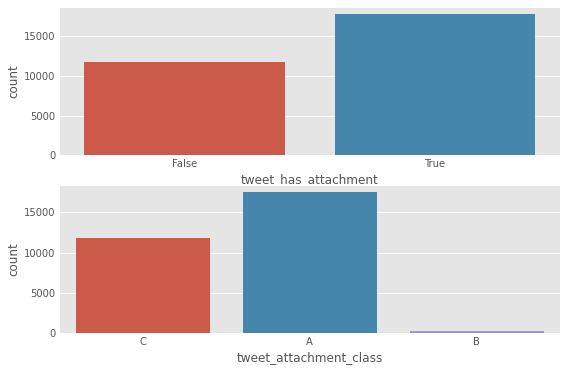

In [72]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

sns.countplot(x = 'tweet_has_attachment', data = train_tweets, ax = axs[0])
sns.countplot(x = 'tweet_attachment_class', data = train_tweets, ax = axs[1])
plt.show()

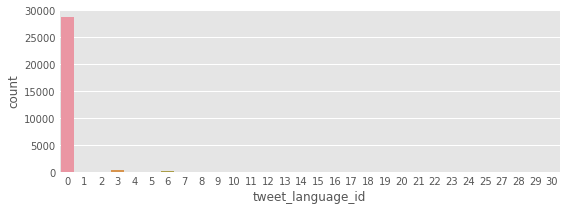

In [75]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3))
sns.countplot(x = 'tweet_language_id', data = train_tweets, ax = axs)
plt.show()

### Tweet Virality

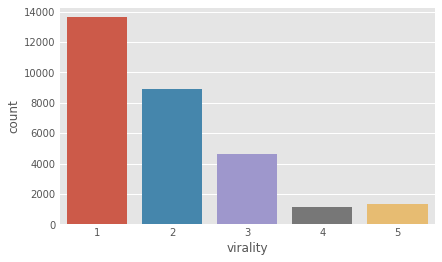

In [55]:
sns.countplot(x = 'virality', data = train_tweets)
plt.show()

### Correlation Matrix

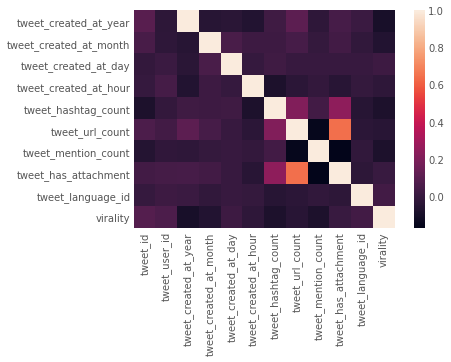

In [88]:
corrmat = train_tweets.corr()[2:] 
sns.heatmap(corrmat, square=True);

In [99]:
df_corr = train_tweets.corr()['virality'][2:-1]
top_features = df_corr.sort_values(ascending=False, key=abs)
top_features

tweet_created_at_year    -0.096487
tweet_hashtag_count      -0.083262
tweet_mention_count      -0.081958
tweet_created_at_month   -0.063757
tweet_url_count          -0.047833
tweet_language_id         0.030416
tweet_created_at_hour    -0.028583
tweet_created_at_day      0.017518
tweet_has_attachment      0.005401
Name: virality, dtype: float64

## Users

In [100]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   user_id                52 non-null     int64
 1   user_like_count        52 non-null     int64
 2   user_followers_count   52 non-null     int64
 3   user_following_count   52 non-null     int64
 4   user_listed_on_count   52 non-null     int64
 5   user_has_location      52 non-null     bool 
 6   user_tweet_count       52 non-null     int64
 7   user_has_url           52 non-null     bool 
 8   user_verified          52 non-null     int64
 9   user_created_at_year   52 non-null     int64
 10  user_created_at_month  52 non-null     int64
dtypes: bool(2), int64(9)
memory usage: 3.9 KB


In [ ]:
### User Metrics


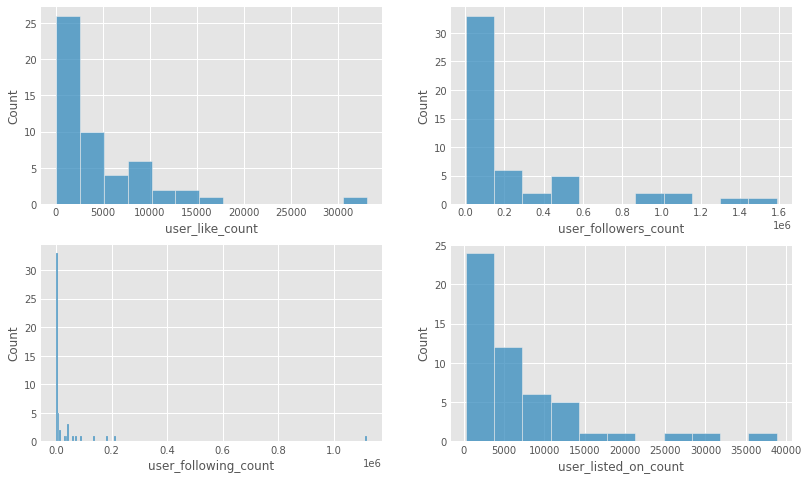

In [101]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(users, x = 'user_like_count', ax = axs[0,0]);
sns.histplot(users, x = 'user_followers_count', ax = axs[0,1]);
sns.histplot(users, x = 'user_following_count', ax = axs[1,0]);
sns.histplot(users, x = 'user_listed_on_count', ax = axs[1,1]);